# Implementation of a LIF neuron with conductance based synapses in Nengo

This notebook implemements a single population of LIF neurons with conductance based synapses as a node within a Nengo simulation.

In [1]:
%matplotlib inline

import nengo
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class IfCondExp(nengo.LIF):
    """
    The IfCondExp class represents a population of IfCondExp neurons.
    Is used both as a storage for the neuron and synapse parameters, as well as the neuron
    and synapse state.
    """

    def __init__(self, n_neurons,
                 tau_rc=20.0e-3,
                 tau_ref=2.0e-3,
                 e_rev_E=4.33,          # equivalent to 0mV for v_rest=-65mV and v_thresh=-50mV
                 e_rev_I=-0.33,         # equivalent to -70mV
                 tau_syn_E=5.0e-3,
                 tau_syn_I=5.0e-3):
        """
        Constructor of the IfCondExp neuron class, copies the given parameters
        and instantiates the internal state vectors. State vectors represent the
        membrane potential, the refractory time, and the conductivity of the
        excitatory and inhibitory synapses for each individual neuron.

        n_neurons: number of neurons in the population.
        tau_rc: membrane time constant of the underlying LIF neuron
        tau_ref: refractory period of the underlying LIF neuron
        e_rev_E: reversal potential of the excitatory synapse. Potentials are
        normalised in such a way that a value zero corresponds to the resting
        potential and a value of one to the threshold potential.
        e_rev_I: reversal potential of the inhibitory synapse.
        tau_syn_E: time constant of the exponential decay of the excitatory
        synapse conductivity.
        tau_syn_I: time constant of the exponential decay of the excitatory
        synapse conductivity.
        """
        # Instantiate the base class
        super(IfCondExp, self).__init__(
            tau_rc=tau_rc,
            tau_ref=tau_ref)

        # Copy all other parameters
        self.n_neurons = n_neurons
        self.e_rev_E = e_rev_E
        self.e_rev_I = e_rev_I
        self.tau_syn_E = tau_syn_E
        self.tau_syn_I = tau_syn_I

        # Instantiate some state vectors
        self.g_E = np.zeros(n_neurons)
        self.g_I = np.zeros(n_neurons)
        self.refractory_time = np.zeros(n_neurons)
        self.voltage = np.zeros(n_neurons)

    def update_synapses(self, dt, A, E_pos, D_pos, E_neg, D_neg):
        """
        Updates the synaptic state for the given input A and computes the
        current that is currently being injected into the membrane, based
        on the synaptic conductivities and the momentary membrane potential.

        dt: simulation timestep to be used.
        A: pre synaptic neuron population activity vector.
        E_pos: encoders for the positive coefficients in the weight matrix.
        D_pos: decoders for the positive coefficients in the weight matrix.
        E_neg: encoders for the negative coefficients in the weight matrix.
        D_neg: decoders for the negative coefficients in the weight matrix.
        """

        # Process incomming spikes by incrementing the conductivity.
        # Note: the scaling factor ensures a unit-area below the synaptic
        # filter.
        self.g_E += dt / self.tau_syn_E * E_pos @ (D_pos @ A)
        self.g_I += dt / self.tau_syn_I * E_neg @ (D_neg @ A)

        # Calculate the current currently induced into the membrane.
        # The scaling factors can be multiplied into the synaptic
        # weights (or the gain).
        scale_E = 1 / ( self.e_rev_E - 0.5)
        scale_I = 1 / (-self.e_rev_I + 0.5)
        J = (scale_E * self.g_E * (self.e_rev_E - self.voltage) +
             scale_I * self.g_I * (self.e_rev_I - self.voltage))

        # When using this equation, the results must be equivalent to
        # the LIF model with current based synapse
        #J = self.g_E - self.g_I

        # Implement the exponential decay of the synaptic currents
        self.g_E -= dt * self.g_E / self.tau_syn_E
        self.g_I -= dt * self.g_I / self.tau_syn_I

        return J

In [3]:
def sim_if_cond_exp(decoder, encoder, bias, gain, model = None):
    """
    Function which setups the simulation functor that can be pluged into a
    Nengo Node object.

    decoder: decoders of the pre-population for the chosen function.
    encoder: encoders that should be used for this population.
    bias: bias values that should be used for this population.
    gain: gain values that should be used for this population.
    model: instance of the IfCondExp class defined above. If None
    is given, a new instance with default parameters is used, with
    the number of neurons derived from the encoder matrix dimensionality.
    """
    
    # Fetch the number of neurons from the encoded dimensionality
    n_neurons = encoder.shape[0]

    # Default to the standard IfCondExp parameters
    if model is None:
        model = IfCondExp(n_neurons)

    # Make sure the dimensions in the input are correct
    assert(encoder.shape[0] == bias.shape[0] == gain.shape[0] == model.n_neurons)
    assert(encoder.shape[1] == decoder.shape[0])
    
    def factorise_weights(weights):
        # Perform a SVD of the weight matrix
        U, S, V = np.linalg.svd(weights)
    
        # Calculate the number of dimensions needed to
        # represent the weight matrix
        k = np.sum(S > 1e-2 * np.max(S))
    
        # Return the encoder/decoder pair which approximates the input matrix
        E, D = (U @ np.diag(S))[:, 0:k], V[0:k, :]
    
        # Make sure the factorisation worked properly
        assert(np.max(np.abs(E @ D - weights)) < 1e-9 * np.max(weights))
        return E, D

    # Calculate the weight matrix, split it into the positive and
    # negative part
    weights = (encoder * gain.reshape(-1, 1)) @ decoder
    w_pos =  weights * (weights > 0)
    w_neg = -weights * (weights < 0)

    # Factorise the weight matrices into positive and negative encoders/
    # decoders (this is not really required, but it speeds up the following
    # computations)
    E_pos, D_pos = factorise_weights(w_pos)
    E_neg, D_neg = factorise_weights(w_neg)

    def simulator(t, A):
        # Calculate the current current induced by the conductance based
        # synapses
        dt = 1e-3

        J = model.update_synapses(dt, A, 
                                  E_pos, D_pos,
                                  E_neg, D_neg) + bias

        # Call the LIF neuron model with the calculated J
        spiked = np.zeros(n_neurons)
        model.step_math(dt, J, spiked, model.voltage, model.refractory_time)
        
        return spiked
    return simulator

In [4]:
#
# Nengo network using the above code
#

# Number of neurons in each of the simulations A, B, C
NA = NB = NC = 50

# Simulation runtime
T = 1.0

# Input function
f = lambda t: (t - 0.5) / 0.5

# Setup the Network object
model = nengo.Network()
with model:
    # Get some fixed seed
    seedA, seedB, seedC = np.random.randint(np.iinfo(np.int32).max, size=3)

    # Generate three ensembles with linear connections
    a = nengo.Ensemble(n_neurons=NA, dimensions=1, seed=seedA)
    b1 = nengo.Ensemble(n_neurons=NB, dimensions=1, seed=seedB)
    c1 = nengo.Ensemble(n_neurons=NC, dimensions=1, seed=seedC)
    con_1 = nengo.Connection(a, b1)
    con_2 = nengo.Connection(b1, c1)

    # Create a simulator in order to calculate the decoders
    with nengo.Simulator(model, seed=3) as sim:
        decoder = sim.data[con_1].weights
        decoder2 = sim.data[con_2].weights
        encoder = sim.data[b1].encoders
        bias = sim.data[b1].bias
        gain = sim.data[b1].gain

    # Create a node which replaces ensemble b
    b2 = nengo.Node(sim_if_cond_exp(decoder, encoder, bias, gain),
                    size_in=a.n_neurons,
                    size_out=NB)

    # Add another target ensemble
    c2 = nengo.Ensemble(n_neurons=NC, dimensions=1, seed=seedC)

    # Wire up the additional ensemble
    nengo.Connection(a.neurons, b2, seed=seedA, synapse=None)
    nengo.Connection(b2, c2, seed=seedA, transform=decoder2)

    # Feed some input into ensemble A
    src = nengo.Node(f)
    nengo.Connection(src, a, seed=seedA)

    # Record the output for c1 and c2
    p1 = nengo.Probe(c1, "decoded_output", synapse=0.01)
    p2 = nengo.Probe(c2, "decoded_output", synapse=0.01)

    # Record the spikes of b1
    p3 = nengo.Probe(b1.neurons, "spikes")


Building finished in 0:00:01.                                                   


In [5]:
# Run the simulation
t = np.arange(0, T, 1e-3)
sim = nengo.Simulator(model, seed=3)
sim.run(T)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


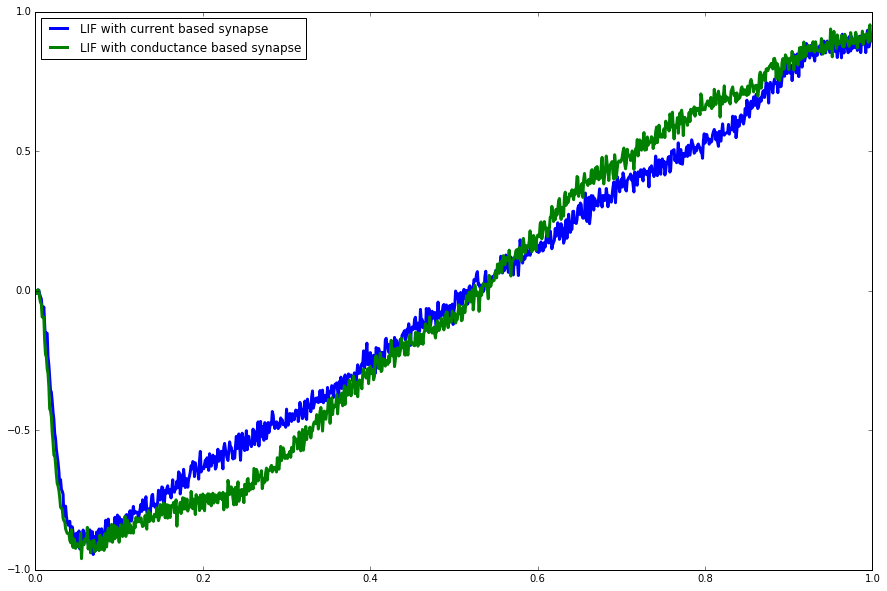

In [6]:
# Plot the results
fig = plt.figure(figsize=(15, 10))
ax = fig.gca()
ax.plot(t, sim.data[p1], label="LIF with current based synapse", linewidth=3)
ax.plot(t, sim.data[p2], label="LIF with conductance based synapse", linewidth=3)
ax.legend(loc="best")

—————— ✁ ———————————— ✁ ———————————— ✁ ———————————— ✁ ——————

In [7]:
#
# Implementation of a population of LIF neurons with current based
# synapses as a node. This code can be used as a skeleton for the
# implementation of custom neuron/synapse models as a node within
# a Nengo simulation.
#

%matplotlib inline

import nengo
import numpy as np
import matplotlib.pyplot as plt

def sim_lif(decoder, encoder, bias, gain):
    
    # Make sure the dimensions in the input are correct
    assert(encoder.shape[0] == bias.shape[0] == gain.shape[0])
    assert(encoder.shape[1] == decoder.shape[0])
    n_neurons = encoder.shape[0]

    # Synaptic time constant
    tau_syn = 5.0e-3

    # Arrays containing the neuron/synapse state
    J_syn = np.zeros(n_neurons)
    voltage = np.zeros(n_neurons)
    refractory_time = np.zeros(n_neurons)

    def simulator(t, A):
        dt = 1e-3
        spiked = np.zeros(n_neurons)

        J_syn[...] = J_syn + dt / tau_syn * encoder @ (decoder @ A) * gain
        J = J_syn + bias
        J_syn[...] = J_syn - dt * J_syn / tau_syn
       
        nengo.LIF().step_math(dt, J, spiked, voltage, refractory_time)
        return spiked
    return simulator
